In [1]:
from langchain.agents import AgentExecutor, Tool, AgentType, initialize_agent
from dotenv import load_dotenv
from langchain.memory import ConversationBufferMemory
from pydantic import BaseModel, Field
from typing import List, Dict, Any, Optional
from langchain_groq import ChatGroq
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from typing import Dict, List, TypedDict, Literal, Union
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown
from langchain_openai import ChatOpenAI
import os
import json
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY_API_KEY"]=os.getenv("GOOGLE_API_KEY")

In [2]:
# filename = "req_build.md"
# with open(filename) as f:
#     s = f.read()
# s

In [3]:
# from IPython.display import Markdown, display
# display(Markdown(s))

In [4]:
def load_llm_models(model_name: str = None):
    # deepseek-r1-distill-qwen-32b
    # llama-3.2-1b-preview
    # qwen-2.5-coder-32b
    # qwen-2.5-32b
    # mixtral-8x7b-32768
    # return ChatGroq(model="deepseek-r1-distill-qwen-32b")
    llm_models = [
        { "model_deepseek": "deepseek-r1-distill-qwen-32b" },
        { "model_llama": "llama-3.2-1b-preview" },
        { "model_qwen_coder": "qwen-2.5-coder-32b" },
        { "model_qwen": "qwen-2.5-32b" },
        { "model_mixtral": "mixtral-8x7b-32768" },
        { "model_openai": "gpt-4" }
    ]

    llm_model = next((model[model_name] for model in llm_models if model_name in model), "")
    # [model[model_name] for model in llm_models if model_name in model]
    # llm_model = [model.values() for model in llm_models if model_name in model.keys()]
    return llm_model

# def load_reviewer_model():
#     return ChatGroq(model="qwen-2.5-32b")

In [5]:
# llms = load_llm_models("model_qwen")
# llms
# llms['model_deepseek']

In [6]:
class GraphState(TypedDict):
    """A graph state, which is a dictionary of node states."""
    user_requirement:str
    generated_user_stories:str
    po_review_comment:str
    stories_correction_iteration:int = 0
    design_doc:str
    design_doc_review_count:int = 0
    design_doc_review_comments:str
    generated_code: str
    code_review_comments:str
    code_review_iteration:int = 0
    security_review_comments:str
    security_review_iteration: int = 0
    generated_test_cases: str
    test_case_review_comments: str
    test_case_review_iteration: int = 0
    messages: List[Union[HumanMessage, SystemMessage, AIMessage]]
    # generated_review_comment:str
    # generated_doc_string:str
    # messages: List[Union[HumanMessage, SystemMessage, AIMessage]]
    # next: Literal["coder_node", "reviewer_node", "manager_node", "next_node", "end"]

In [7]:
def get_user_requirements_test():
    """ Agent that takes in the user requirements """
    filename = "req_build.md"
    with open(filename) as f:
        user_requirements = f.read()
    return user_requirements
    # return { "user_requirement": user_requirements }
    

In [8]:

def get_user_requirements_node(state: GraphState) -> GraphState:

    """ Agent that takes in the user requirements """

    print("Getting user requirements...")
    
    filename = "req_build.md"
    with open(filename) as f:
        user_requirements = f.read()
    # return user_requirements
    return { "user_requirement": user_requirements }

In [9]:
# user_req = get_user_requirements()
# user_req

In [10]:
def extract_content_after_pattern(text):
    pattern = "\n</think>\n\n"
    # Find the position of the pattern
    position = text.find(pattern)
    
    if position == -1:
        # Pattern not found
        return None
    
    # Calculate the position after the pattern
    start_position = position + len(pattern)
    
    # Return everything after the pattern
    return text[start_position:]

In [11]:
# def generate_user_stories_test():
#     llm = ChatGroq(model=load_llm_models("model_llama"))
#     user_requirements = get_user_requirements_test()

#     messages = [
#         SystemMessage(content="You are a expert Product Manager. Your job is to Create well structured and comprehenvise User Stories for the given requirement for the developers to implement and return the response as python list"),
#         HumanMessage(content=f"Generate List of User Stories for requirement {user_requirements}.Each User story should have a title, description, acceptance criteria, priority and status.Acceptance criteria must include specific details about the validation too")
#                     #  If peer comments are provided in {generated_review_comment}, you will implemet those changes too in the code")
#     ]
    
#     response = llm.invoke(messages)
#     generated_user_stories = response.content.strip()
#     # return { "generated_user_stories": generated_user_stories }
#     return generated_user_stories

# gen_test = generate_user_stories_test()
# gen_test

In [12]:

def generate_user_stories_node(state: GraphState) -> GraphState:

    """ Agent that takes the user requirements and generates user stories """
    
    # llm = ChatOpenAI(model="gpt-4")
    current_state = state
    # llm = ChatGroq(model=load_llm_models("model_llama"))
    llm = ChatGroq(model="deepseek-r1-distill-llama-70b")
    user_requirements = current_state['user_requirement']
    po_review_comment = current_state['po_review_comment']
    stories_correction_iteration = current_state['stories_correction_iteration']

    print("Generating or revising user stories ...")

    messages = [
        SystemMessage(content="You are a expert Product Manager. Your job is to Create Well structured User Stories code for the given requirement for the developers to implement and return the response as python list and if feedbacks are provided for the user stories, you will modify them based on the feedbacks"),
        HumanMessage(content=f"Generate List of User Stories for requirement {user_requirements} or if feedbacks are provided on user stories in {po_review_comment}, you will modify them based on the feedbacks.Each User story should have a title, description, acceptance criteria, priority and status")
    ]
    
    response = llm.invoke(messages)
    generated_user_stories = response.content.strip()
    user_stories = generated_user_stories
    # user_stories = extract_content_after_pattern(generated_user_stories)
    stories_correction_iteration += 1
    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"Generated User Stories : { user_stories}")
    ]
    
    return {
       "user_requirement": state["user_requirement"],
        "generated_user_stories": user_stories,
        "stories_correction_iteration": stories_correction_iteration,
        "po_review_comment": current_state["po_review_comment"],
        "design_doc_review_count": current_state["design_doc_review_count"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }


In [ ]:
def po_review_stories_node(state: GraphState) -> GraphState:
    """ Agent that takes the user stories and generates a review comment """
    # Get the current graph state
    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    
    
    print("PO is reviewing User stories ...")

    # Get the messages
    messages = current_state["messages"]
    # Get the reviewer model
    # llm = ChatOpenAI(model="gpt-4")
    # llm = ChatGroq(model="gemma2-9b-it")
    # llm = ChatGroq(model=load_llm_models("model_llama"))
    llm = ChatGroq(model="deepseek-r1-distill-qwen-32b")
    # llm = ChatGroq(model=load_llm_models("model_qwen"))
    messages = [
        SystemMessage(content="You are a Product Owner. Your job is to provide feedback on User Stories against the given requirement and either approve it or provide feedback.The goal is to build MVP first i.e build product fast and then iterate on it, keep this in mind while providing feedback"),
        HumanMessage(content=f"Review the List of User Stories {user_stories} against requirement {user_requirements}. If you approve of all the user stories then mention 'Here is my approval for all user stories' in your review comments else provide feedback on the user stories with the changes required and start your comments with 'Here are the changes required' and dont mention word 'approved' anywhere in your comments.The goal is to build MVP first i.e build product fast and then iterate on it, keep this in mind while providing feedback.")
                    #  If peer comments are provided in {generated_review_comment}, you will implemet those changes too in the code")
    ]
    
    response = llm.invoke(messages)

   # Get the response from the reviewer model
    po_review_comment = response.content.strip()

    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"Generated Product Owner Review comment for stories : { po_review_comment }")
    ]
    
    return {
       "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": po_review_comment,
        "design_doc_review_count": current_state["design_doc_review_count"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [14]:
def create_design_doc_node(state: GraphState)-> GraphState:
    """ Agent that takes the user stories and creates FDD and TDD """

    # Get the current graph state
    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    design_doc_review_count = current_state["design_doc_review_count"]
    design_doc_review_comments = current_state["design_doc_review_comments"]
    # Get the messages
    messages = current_state["messages"]
    # Get the reviewer model
    # llm = ChatOpenAI(model="gpt-4")
    # llm = ChatGroq(model="gemma2-9b-it")
    # llm = ChatGroq(model=load_llm_models("model_llama"))
    # llm = ChatGroq(model=load_llm_models("model_qwen"))
    print("Generating or revising Functional and Techinal Design documents ...")

    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        # max_retries=2,
    # other params...
    )
    
    messages = [
        SystemMessage(content="You are a Software Architect with strong business analysis skills. Your job is to create a comprehensive Functional and Technical design documents of great quality against given requirement and user stories.You also want to keep review comments to minimum when reviewed by another architect.The goal is to build MVP first i.e build product fast and then iterate on it, keep this in mind while designing the documents"),
        HumanMessage(content=f"Create Functional and Technical design documents based on {user_stories} against requirement {user_requirements}.If feedback is present in { design_doc_review_comments } you will modify the document accordingly while trying to keep {design_doc_review_count} less than 5. The goal is to build MVP first i.e build product fast and then iterate on it, keep this in mind designing the documents.Return document in markdown format.")
    ]
    design_doc_review_count += 1
    response = llm.invoke(messages)

    # Get the response from the reviewer model
    design_doc = response.content.strip()

    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"Generated functional and technical design doc : { design_doc }")
    ]
    
    return {
        "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": current_state["po_review_comment"],
        "design_doc": design_doc,
        "design_doc_review_count": design_doc_review_count,
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [15]:
def design_doc_review_node(state: GraphState)-> GraphState:
    """ Agent that reviews FDD and TDD """

    # Get the current graph state
    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    design_doc = current_state["design_doc"]
    # review_count = current_state["review_count"]
    # Get the messages
    messages = current_state["messages"]
    # Get the reviewer model
    # llm = ChatOpenAI(model="gpt-4")
    # llm = ChatGroq(model="gemma2-9b-it")
    # llm = ChatGroq(model="llama-3.2-3b-preview")

    print("Review of Functional and Techinal Design documents ...")
    
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        # max_retries=2,
    # other params...
    )
    # llm = ChatGroq(model=load_llm_models("model_qwen"))
    # llm = ChatGroq(model=load_llm_models("model_qwen"))
    messages = [
        SystemMessage(content="You are a Software Architect. Your job is to review Functional and Technical design documents against given requirement and user stories.Dont nitpick and liberal while providing feedback"),
        HumanMessage(content=f"Review the Functional and Technical design documents {design_doc} based on {user_stories} and requirement {user_requirements}.If you are happy with the documents, mention 'Go ahead, Here is my approval for the design documents' or else provide feedback on the documents and start your comments with 'Here are the changes required' and dont mention word 'approved' anywhere in your comments.Be liberal while providing feedback.")
    ]

    response = llm.invoke(messages)

    # Get the response from the reviewer model
    design_doc_review_comments = response.content.strip()

    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"functional and technical design doc review comments: { design_doc_review_comments }")
    ]
    
    return {
        "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": current_state["po_review_comment"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": design_doc_review_comments,
        "design_doc_review_count": current_state["design_doc_review_count"],
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [ ]:
def coder_node(state: GraphState)-> GraphState:
    """ Agent that generates code after taking in the requirements,stories and design doc"""
    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    design_doc = current_state["design_doc"]
    code_review_comments = current_state["code_review_comments"]
    code_review_iteration = current_state["code_review_iteration"]
    security_review_comments = current_state["security_review_comments"]
    
    # Get the messages
    messages = current_state["messages"]
    
    messages = [
        SystemMessage(content="You are a expert python coder. Your job is to create python code for the given requirement, user stories and design document that will accurately implement the functionality. If peer review comments are provided you implemet those changes to code accordingly."),
        HumanMessage(content=f"Generate the python code as per the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc}. If peer comments are provided in {code_review_comments} or security review aspect of code is present in {security_review_comments}, you will implement those changes too in the code")
    ]

    print("Generating or revising code ...")

    # llm = ChatGroq(model=load_llm_models("model_qwen_coder"))
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        # max_retries=2,
    # other params...
    )
    code_review_iteration += 1
    # if security_review_comments!="":
    #     security_review_iteration += 1

    response = llm.invoke(messages)
    generated_code = response.content.strip()
    # print(generated_code)

    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"Generated Code: {generated_code}")
    ]
    
    return {
        "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": current_state["po_review_comment"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "design_doc_review_count": current_state["design_doc_review_count"],
        "generated_code": generated_code,
        "code_review_comments": current_state["code_review_comments"],
        "code_review_iteration": code_review_iteration,
        "security_review_comments": current_state["security_review_comments"],
        # "security_review_iteration": security_review_iteration,
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [17]:
def code_reviewer_node(state: GraphState) -> GraphState:
    """Agent that peer reviews the generated code for the provided requirement."""

    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    design_doc = current_state["design_doc"]
    code_review_comments = current_state["code_review_comments"]
    generated_code = current_state["generated_code"]
    # Get the messages
    messages = current_state["messages"]

    messages = [
            SystemMessage(content="You are an code reviewer. Your job is to review the code against the given requirement,stories and design doc and check if it implements all the functionalities and covers all scenarios and provide review comments.Return 'no additional review comments' in your review comment if you find the code is good enough."),
            HumanMessage(content=f"Peer review the code {generated_code} against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc} and provide your review comments on the code, dont nitpick while providing your review comments. Return 'no additional review comments' in your review comment if you find the code is good enough.")
        ]

    print("Code Review in progress ...")
    # llm = ChatGroq(model=load_llm_models("model_qwen_coder"))
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        # max_retries=2,
    # other params...
    )
    response = llm.invoke(messages)
    code_review_comments = response.content.strip()
    # print(generated_code)

    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"Generated code review comments: {code_review_comments}")
    ]
    
    return {
        "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": current_state["po_review_comment"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "design_doc_review_count": current_state["design_doc_review_count"],
        "generated_code": current_state["generated_code"],
        "code_review_comments": code_review_comments,
        "code_review_iteration": current_state["code_review_iteration"],
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [18]:
def security_review_node(state: GraphState) -> GraphState:
    """ Agent that does the security review of the generated code for the provided requirement."""

    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    design_doc = current_state["design_doc"]
    generated_code = current_state["generated_code"]
    security_review_iteration = current_state["security_review_iteration"]
    # Get the messages
    messages = current_state["messages"]

    messages = [
            SystemMessage(content="You are an Software Security Engineer. Your job is to review the security aspects of code against the given requirement,stories and design doc and provide security review feedback based on which developer can change code accordingly.Return 'no additional security review comments' in your feedback if you find the code is good enough wrt security."),
            HumanMessage(content=f"Do the security review of the code {generated_code} against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc} and provide your feedback on the code wrt secuity, dont nitpick while providing your feedback. Return 'no additional security review comments' in your feedback if you find the code is good enough.")
        ]

    print("Security Review in progress ...")
    # llm = ChatGroq(model=load_llm_models("model_qwen_coder"))
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        # max_retries=2,
    # other params...
    )
    response = llm.invoke(messages)
    security_review_comments = response.content.strip()
    security_review_iteration += 1
    # print(generated_code)

    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"Generated security review comments: {security_review_comments}")
    ]
    
    return {
        "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": current_state["po_review_comment"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "design_doc_review_count": current_state["design_doc_review_count"],
        "generated_code": current_state["generated_code"],
        "code_review_comments": current_state["code_review_comments"],
        "code_review_iteration": current_state["code_review_iteration"],
        "security_review_comments": security_review_comments,
        "security_review_iteration": security_review_iteration,
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [ ]:
def write_test_cases_node(state: GraphState)-> GraphState:
    """ Agent that writes test cases for the provided requirement."""

    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    design_doc = current_state["design_doc"]
    security_review_comments = current_state["security_review_comments"]
    test_case_review_comments = current_state["test_case_review_comments"]
    test_case_review_iteration = current_state["test_case_review_iteration"]
    # Get the messages
    messages = current_state["messages"]

    print("Generating or revising Test cases ...")

    messages = [
            SystemMessage(content="You are an Software Development Engineer in Test (SDET). Your job is to write test cases against the given requirement,stories,design doc and security review comments."),
            HumanMessage(content=f"Write test cases against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc}, Security Review comments: {security_review_comments}.If you find feedback in {test_case_review_comments}, you will modify test cases accordingly.")
        ]

    # llm = ChatGroq(model=load_llm_models("model_qwen_coder"))
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        # max_retries=2,
    # other params...
    )
    response = llm.invoke(messages)
    generated_test_cases = response.content.strip()
    test_case_review_iteration += 1 
 
    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"Generated test cases: {generated_test_cases}")
    ]
    
    return {
        "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": current_state["po_review_comment"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "design_doc_review_count": current_state["design_doc_review_count"],
        "generated_code": current_state["generated_code"],
        "code_review_comments": current_state["code_review_comments"],
        "code_review_iteration": current_state["code_review_iteration"],
        "security_review_comments": current_state["security_review_comments"],
        "security_review_iteration": current_state["security_review_iteration"],
        "generated_test_cases": generated_test_cases,
        "test_case_review_iteration": test_case_review_iteration,
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [20]:
def test_case_review_node(state: GraphState)-> GraphState:
    """ Agent that reviews test cases and provides review comments """

    current_state = state
    # Get the user stories and requirements
    user_requirements = current_state["user_requirement"]
    user_stories = current_state["generated_user_stories"]
    design_doc = current_state["design_doc"]
    # generated_code = current_state["generated_code"]
    generated_test_cases = current_state["generated_test_cases"]
    security_review_comments = current_state["security_review_comments"]

    # Get the messages
    messages = current_state["messages"]

    print("Reviewing Test cases ...")

    messages = [
            SystemMessage(content="You are an QA Lead/Manager. Your job is to review test cases against the given requirement,stories,design doc and security review comments and provide feedback.Return 'no additional test case review comments' in your review comment if you find the code is good enough."),
            HumanMessage(content=f"Review test cases : { generated_test_cases } against the requirement: {user_requirements}, user stories: {user_stories}, Functional and Technical Design: {design_doc}, Security Review comments: {security_review_comments} and provide feedback.Dont nitpick while providing your feedback. Return 'no additional test case review comments' in your feedback if you find the test cases coverage are good enough.")
        ]

    # llm = ChatGroq(model=load_llm_models("model_qwen_coder"))
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        # max_retries=2,
    # other params...
    )
    response = llm.invoke(messages)
    test_case_review_comments = response.content.strip()
 
    # Update state
    new_messages = state["messages"] + messages + [
        AIMessage(content=f"test case review comments: {test_case_review_comments}")
    ]
    
    return {
        "user_requirement": current_state["user_requirement"],
        "generated_user_stories": current_state["generated_user_stories"],
        "stories_correction_iteration": current_state["stories_correction_iteration"],
        "po_review_comment": current_state["po_review_comment"],
        "design_doc": current_state["design_doc"],
        "design_doc_review_comments": current_state["design_doc_review_comments"],
        "design_doc_review_count": current_state["design_doc_review_count"],
        "generated_code": current_state["generated_code"],
        "code_review_comments": current_state["code_review_comments"],
        "code_review_iteration": current_state["code_review_iteration"],
        "security_review_comments": current_state["security_review_comments"],
        "security_review_iteration": current_state["security_review_iteration"],
        "generated_test_cases": current_state["generated_test_cases"],
        "test_case_review_comments": test_case_review_comments,
        "messages": new_messages,
        # "next": state["reviewer_node"]
    }

In [21]:
def qa_testing_node(state: GraphState) -> GraphState:
    pass

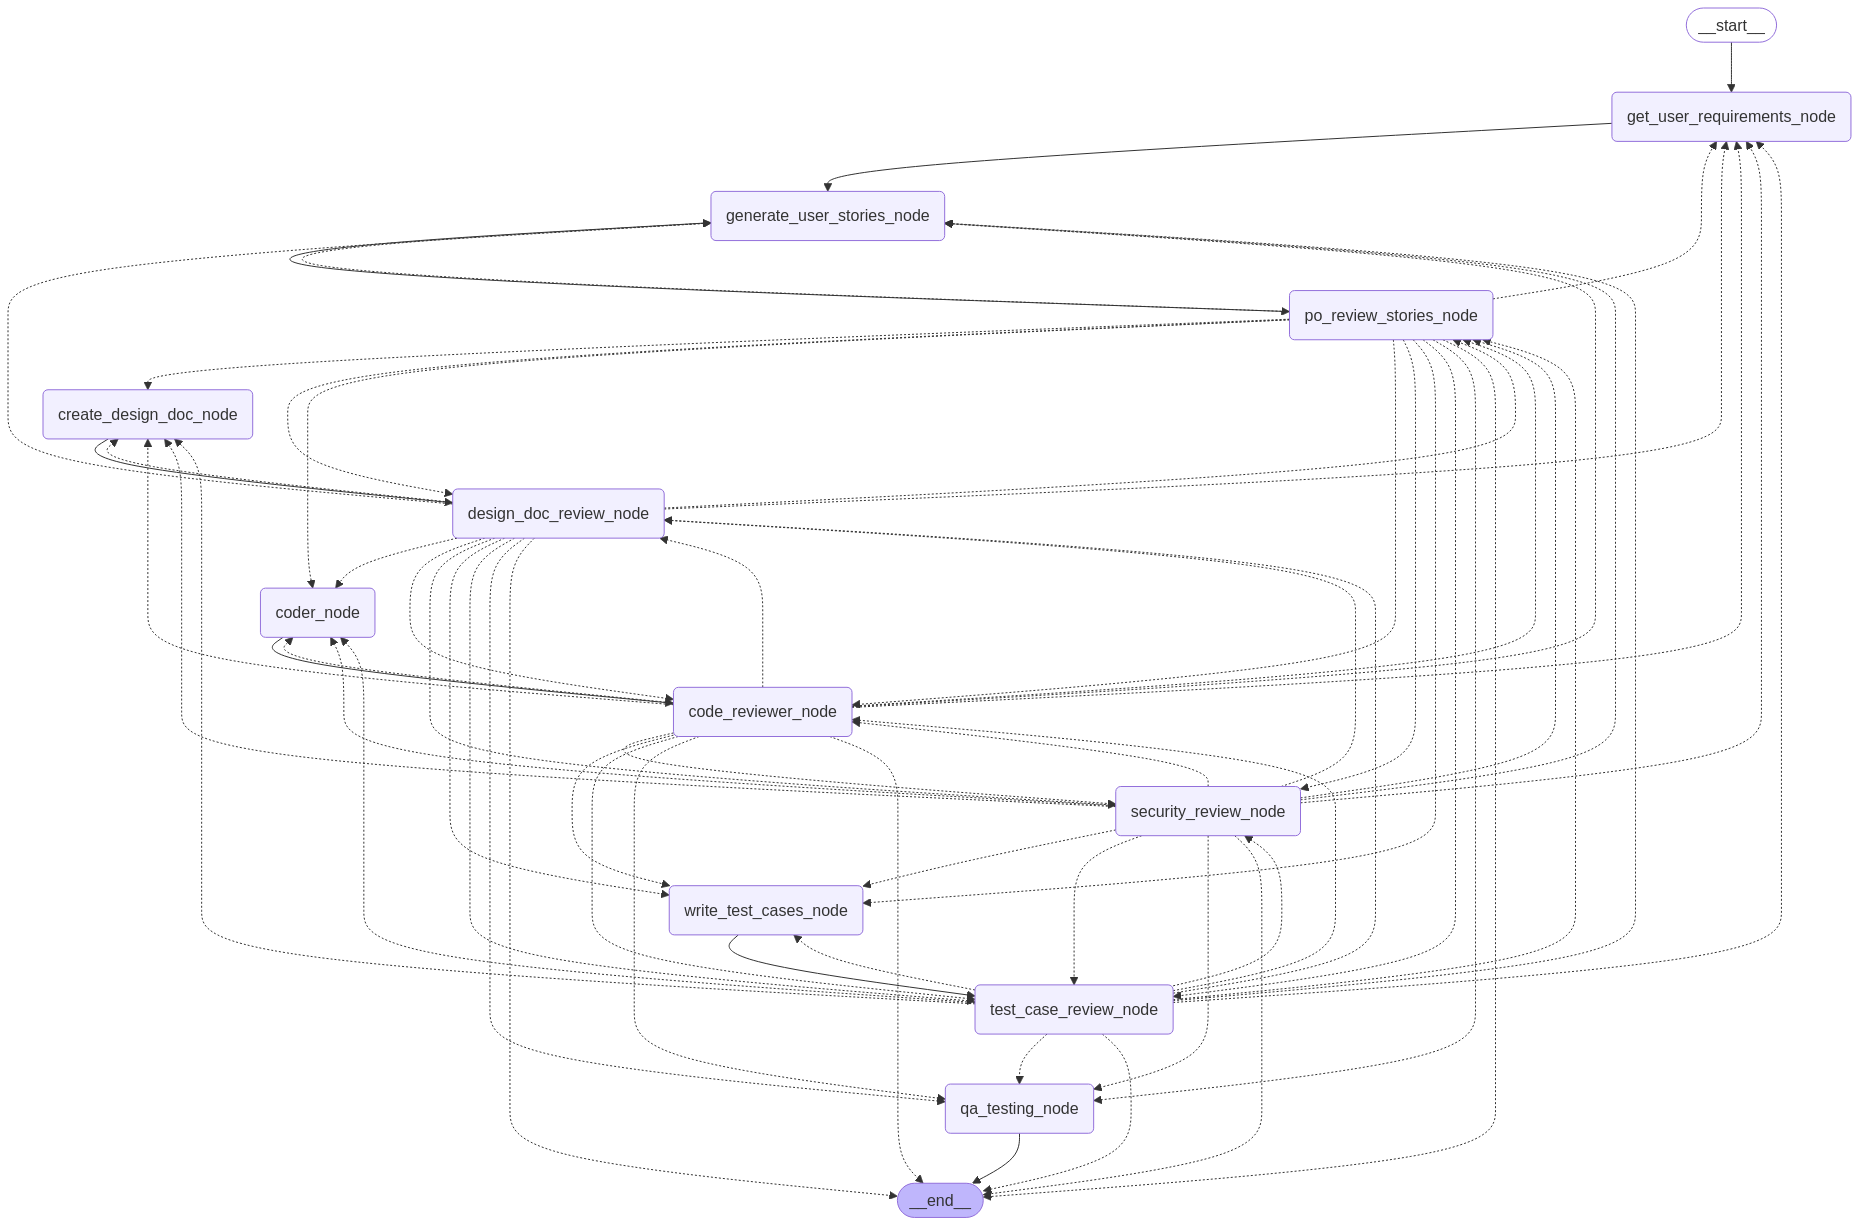

In [22]:
#Build the Graph

builder=StateGraph(GraphState)

## Define the node

builder.add_node("get_user_requirements_node", get_user_requirements_node)
builder.add_node("generate_user_stories_node", generate_user_stories_node)
builder.add_node("po_review_stories_node", po_review_stories_node)
builder.add_node("create_design_doc_node", create_design_doc_node)
builder.add_node("design_doc_review_node", design_doc_review_node)
builder.add_node("coder_node", coder_node)
builder.add_node("code_reviewer_node", code_reviewer_node)
builder.add_node("security_review_node", security_review_node)
builder.add_node("write_test_cases_node",write_test_cases_node)
builder.add_node("test_case_review_node",test_case_review_node)
builder.add_node("qa_testing_node",qa_testing_node)

correction_phrase = "Here are the changes required".lower()
approved_phrase = "approved".lower()
## Define the edges
builder.add_edge(START, "get_user_requirements_node")
# After getting requirements, generate user stories
builder.add_edge("get_user_requirements_node", "generate_user_stories_node")
builder.add_edge("generate_user_stories_node", "po_review_stories_node")

MAX_ITERATIONS = 10

def review_condition_stories(state):

    print("stories_correction_iteration: ", state['stories_correction_iteration'])
    if "Here is my approval for all user stories".lower() in state.get('po_review_comment', '').lower():
        print("Found Here is my approval for all user stories")
        return "create_design_doc_node"
    elif state['stories_correction_iteration'] < MAX_ITERATIONS:
        return "generate_user_stories_node"
    else:
        return "create_design_doc_node"  # Force move forward after max retries

# Conditional edge for PO review outcome with iteration limit
builder.add_conditional_edges(
    "po_review_stories_node",
    review_condition_stories
)

builder.add_edge("create_design_doc_node", "design_doc_review_node")

def review_condition_design_doc(state):

    print("design_doc_review_count: ", state['design_doc_review_count'])

    if "Go ahead".lower() in state["design_doc_review_comments"].lower():
        print("Found Go Ahead")
        return "coder_node"
    elif state['design_doc_review_count'] < MAX_ITERATIONS:
        return "create_design_doc_node"
    else:
        return "coder_node"  # Force move forward after max retries

# Conditional edge for Design review outcome with iteration limit
builder.add_conditional_edges(
    "design_doc_review_node",
    review_condition_design_doc
)

builder.add_edge("coder_node", "code_reviewer_node")

def review_condition_code_review(state):

    print("code_review_iteration: ", state['code_review_iteration'])

    if "no additional review comments".lower() in state["code_review_comments"].lower():
        print("Found no additional review comments")
        return "security_review_node"
    elif state['code_review_iteration'] < MAX_ITERATIONS:
        return "coder_node"
    else:
        return "security_review_node"  # Force move forward after max retries
    
# Conditional edge for Code review outcome with iteration limit    
builder.add_conditional_edges(
    "code_reviewer_node",
    review_condition_code_review
)

def review_condition_security_review(state):

    print("security_review_iteration: ", state['security_review_iteration'])

    if "no additional security review comments".lower() in state["security_review_comments"].lower():
        print("Found no additional security review comments")
        return "write_test_cases_node"
    elif state['security_review_iteration'] < MAX_ITERATIONS:
        return "coder_node"
    else:
        return "write_test_cases_node"  # Force move forward after max retries
    
# Conditional edge for Code review outcome with iteration limit    
builder.add_conditional_edges(
    "security_review_node",
    review_condition_security_review
)

builder.add_edge("write_test_cases_node", "test_case_review_node")

def review_condition_testcase_review(state):

    print("testcase_review_iteration: ", state['test_case_review_iteration'])

    if "no additional test case review comments".lower() in state["test_case_review_comments"].lower():
        print("Found no additional test case review comments")
        return "qa_testing_node"
    elif state['test_case_review_iteration'] < MAX_ITERATIONS:
        return "write_test_cases_node"
    else:
        return "qa_testing_node"  # Force move forward after max retries
    
# Conditional edge for test case review outcome with iteration limit    
builder.add_conditional_edges(
    "test_case_review_node",
    review_condition_testcase_review
)
    
builder.add_edge("qa_testing_node", END)

# Build the graph
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [23]:
# ## Define the edges
# builder.add_edge(START,"gather_requirement_node")
# # After getting requirements, generate user stories
# builder.add_edge("gather_requirement_node","user_stories_node")
# builder.add_edge("user_stories_node", "po_review_stories_node" )

# # #Review user stories node has conditional routing
# # builder.add_conditional_edges(
# #     "po_review_stories_node",
# #     # Condition to determine next step
# #     lambda state: "create_design_doc_node" if phrase in state['po_review_comment'] else "user_stories_node"
# # )
# # Conditional edge for PO review outcome
# builder.add_conditional_edges(
#     "po_review_stories_node",
#     lambda state: "create_design_doc_node" if "approved" in state.get('po_review_comment', '').lower() else "user_stories_node"
# )

# builder.add_edge("create_design_doc_node", "design_review_node")
# builder.add_edge("design_review_node", END)

# # builder.add_edge("po_review_stories_node", "create_design_doc_node")
# # Manager node leads to end
# # builder.add_edge("create_design_doc_node", "design_review_node")
# # builder.add_edge("design_review_node", END)

# # Build the graph
# react_graph = builder.compile()

# # Show
# display(Image(react_graph.get_graph().draw_mermaid_png()))

In [24]:
def run_workflow() -> Dict:
    """
    Run the workflow for given requirement.
    
    Args:
        Requirement: The functionality that needs to be implemented
        
    Returns:
        Dict containing the generated code, review comment and doc string
    """
    # Initialize state
    initial_state = {
        "user_requirement": "",
        "generated_user_stories": "",
        "po_review_comment": "",
        "stories_correction_iteration": 0,
        'design_doc_review_count': 0,
        'design_doc': "",
        "design_doc_review_comments": "",
        "generated_code": "",
        "code_review_comments": "",
        "code_review_iteration": 0,
        "security_review_comments":"",
        "security_review_iteration": 0,
        "generated_test_cases": "",
        "test_case_review_comments": "",
        "test_case_review_iteration": 0,
        "messages": [HumanMessage(content=f"Getting requirements from file")]
    }
    
    # Run the graph
    result = react_graph.invoke(initial_state, {"recursion_limit": 100})
    

    return {
       "user_requirement": result["user_requirement"],
        "generated_user_stories": result["generated_user_stories"],
        "po_review_comment": result["po_review_comment"],
        "stories_correction_iteration": result["stories_correction_iteration"],
        "design_doc_review_count": result["design_doc_review_count"],
        'design_doc': result["design_doc"],
        "design_doc_review_comments": result["design_doc_review_comments"],
        "generated_code": result["generated_code"],
        "code_review_comments": result["code_review_comments"],
        "code_review_iteration": result["code_review_iteration"],
        "security_review_comments": result["security_review_comments"],
        "security review_iteration": result["security_review_iteration"],
        "generated_test_cases": result["generated_test_cases"],
        "test_case_review_comments" : result["test_case_review_comments"],
        "test_case_review_iteration": result["test_case_review_iteration"],
        "messages": result["messages"]
    }

In [25]:
result = run_workflow()

Getting user requirements...
Generating or revising user stories ...
PO is reviewing User stories ...
stories_correction_iteration:  1
Generating or revising user stories ...
PO is reviewing User stories ...
stories_correction_iteration:  2
Found Here is my approval for all user stories
Generating or revising Functional and Techinal Design documents ...
Review of Functional and Techinal Design documents ...
design_doc_review_count:  1
Generating or revising Functional and Techinal Design documents ...
Review of Functional and Techinal Design documents ...
design_doc_review_count:  2
Found Go Ahead
Generating or revising code ...
Code Review in progress ...
code_review_iteration:  1
Found no additional review comments
Security Review in progress ...
security_review_iteration:  1
Generating or revising code ...
Code Review in progress ...
code_review_iteration:  2
Found no additional review comments
Security Review in progress ...
security_review_iteration:  2
Found no additional securit

In [26]:
result

{'user_requirement': 'Build Web app Snake and Ladder Game using Python and Flask',
 'generated_user_stories': '<think>\nOkay, I need to help the user by generating a well-structured list of user stories for building a Snake and Ladder game using Python and Flask. The user also mentioned that if feedback is provided on the user stories, I should modify them based on that feedback. The response should be a Python list, and each user story should have a title, description, acceptance criteria, priority, and status.\n\nFirst, I\'ll start by identifying the key features required for a basic Snake and Ladder game. The core components include setting up the game board, handling dice rolls, moving players, implementing snakes and ladders, initializing the game, managing turns, handling game over conditions, resetting the game, and displaying game status.\n\nFor each of these features, I\'ll create a user story. Each story should be written from the perspective of the user, focusing on what the

In [27]:
# if approved_phrase in result['po_review_comment'].lower():
#    print(1)
# else:
#     print(0)

In [28]:
# user_stories = generate_user_stories()
# print(user_stories)
# print("#"*100)
# user_stories_list = extract_content_after_pattern(user_stories)
# print(user_stories_list)

In [29]:
# print(user_stories_list)